In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### 1. Data Ingestion

In [2]:
df = pd.read_csv('data.csv')
df.sample(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4057,7980-MHFLQ,Female,0,Yes,Yes,72,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,24.90,1859.2,No
4899,1565-RHDJD,Female,0,No,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),84.05,333.55,Yes
4863,8727-JQFHV,Male,0,Yes,Yes,57,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.75,1123.15,No


### 2. Data Preparation

In [3]:
# Observing the column name
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [4]:
# Function to convert camelcase name to snakecase
import re

def camel_to_snake(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [5]:
# Convert column names to snake case
df.columns = [camel_to_snake(col) for col in df.columns]
df.head().T

,0,1,2,3,4
customer_id,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
senior_citizen,0,0,0,0,0
partner,Yes,No,No,No,No
dependents,No,No,No,No,No
tenure,1,34,2,45,2
phone_service,No,Yes,Yes,No,Yes
multiple_lines,No phone service,No,No,No phone service,No
internet_service,DSL,DSL,DSL,DSL,Fiber optic
online_security,No,Yes,Yes,Yes,No


In [6]:
# Checking data type of feature
df.customer_id

0       7590-VHVEG
1       5575-GNVDE
2       3668-QPYBK
3       7795-CFOCW
4       9237-HQITU
           ...    
7038    6840-RESVB
7039    2234-XADUH
7040    4801-JZAZL
7041    8361-LTMKD
7042    3186-AJIEK
Name: customer_id, Length: 7043, dtype: object

In [7]:
# Changing categorical columns value to lowercase and replacing space to underscore
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [8]:
# Converting total_charges to numeric
tc = pd.to_numeric(df.monthly_charges)
df.total_charges = tc

In [9]:
# Checking null values in total_charges
df.total_charges.isnull().sum()
df.total_charges = df.total_charges.fillna(0)

In [10]:
# Checking churn column
df.churn = (df.churn == 'yes').astype('int')

In [11]:
df.dtypes

customer_id           object
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure                 int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
churn                  int32
dtype: object

### 3. Setting Validation Framework

In [12]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [13]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [14]:
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_val = df_test.reset_index(drop=True)

In [16]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [17]:
del df_train['churn']
del df_val['churn']
del df_test['churn']

### 4. Exploratory Data Analysis
- Check missing values
- Look at target variable
- Look at numerical and categorical variable

In [18]:
df_train_full = df_train_full.reset_index(drop=True)
df_train_full

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,19.70,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,73.90,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,65.15,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,85.45,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,70.40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,100.50,1
5630,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,19.95,0
5631,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,105.70,1
5632,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,54.40,1


In [19]:
# Checking missing values
df_train_full.isnull().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

**Observation:** No missing values

In [20]:
# Looing at target variable
df_train_full.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [21]:
# This is the churn rate
df_train_full.churn.mean()

0.26996805111821087

In [22]:
df_train_full.dtypes

customer_id           object
gender                object
senior_citizen         int64
partner               object
dependents            object
tenure                 int64
phone_service         object
multiple_lines        object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
contract              object
paperless_billing     object
payment_method        object
monthly_charges      float64
total_charges        float64
churn                  int32
dtype: object

In [23]:
# List of numerical columns
numerical = ['tenure', 'monthly_charges', 'total_charges']

In [24]:
# List of categorical columns
categorical = ['gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method']

In [25]:
# Unique values for categorical columns
df_train_full[categorical].nunique()

gender               2
senior_citizen       2
partner              2
dependents           2
phone_service        2
multiple_lines       3
internet_service     3
online_security      3
online_backup        3
device_protection    3
tech_support         3
streaming_tv         3
streaming_movies     3
contract             3
paperless_billing    2
payment_method       4
dtype: int64

### 5. Feature Importance
Identify which feature affects most to the target variable:
- churn rate
- rick ratio
- mutual information

#### Churn Rate

In [26]:
# Calculate the global churn
global_churn = df_train_full.churn.mean()
global_churn

0.26996805111821087

In [27]:
# Calculate the female churn
female_churn = df_train_full[df_train_full.gender == 'female'].churn.mean()
female_churn

0.27682403433476394

In [28]:
# Calculate the male churn
male_churn = df_train_full[df_train_full.gender == 'male'].churn.mean()
male_churn

0.2632135306553911

In [29]:
# Calculate churn rate with partner
partner_churn = df_train_full[df_train_full.partner == 'yes'].churn.mean()
partner_churn

0.20503330866025166

In [30]:
# Calculate churn rate with no partner
no_partner_churn = df_train_full[df_train_full.partner == 'no'].churn.mean()
no_partner_churn

0.3298090040927694

In [31]:
global_churn - partner_churn

0.06493474245795922

In [32]:
global_churn - no_partner_churn

-0.05984095297455855

#### Risk Ratio

In [33]:
# Risk ratio with no partner
no_partner_churn / global_churn

1.2216593879412643

In [34]:
# Risk ratio with partner
partner_churn / global_churn

0.7594724924338315

**We can not do this for each column individually. So lets write SQ: query:**

```
SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn as diff,
    AVG(churn) / global_churn as risk,
FROM
    data
GROUP BY
    gender
```
Lets translate this is dataframe:

In [35]:
df_group = df_train_full.groupby('gender').churn.agg(['mean', 'count'])
df_group['diff'] = df_group['mean'] - global_churn
df_group['risk'] = df_group['mean'] / global_churn
df_group.head()

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


In [36]:
# Do this for all columns
for c in categorical:
    print(f'Column name: {c}')
    df_group = df_train_full.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group.head())
    print('-------\n')

Column name: gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


-------

Column name: senior_citizen


,mean,count,diff,risk
senior_citizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


-------

Column name: partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


-------

Column name: dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


-------

Column name: phone_service


,mean,count,diff,risk
phone_service,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


-------

Column name: multiple_lines


,mean,count,diff,risk
multiple_lines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


-------

Column name: internet_service


,mean,count,diff,risk
internet_service,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


-------

Column name: online_security


,mean,count,diff,risk
online_security,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


-------

Column name: online_backup


,mean,count,diff,risk
online_backup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


-------

Column name: device_protection


,mean,count,diff,risk
device_protection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


-------

Column name: tech_support


,mean,count,diff,risk
tech_support,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


-------

Column name: streaming_tv


,mean,count,diff,risk
streaming_tv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


-------

Column name: streaming_movies


,mean,count,diff,risk
streaming_movies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


-------

Column name: contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


-------

Column name: paperless_billing


,mean,count,diff,risk
paperless_billing,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


-------

Column name: payment_method


,mean,count,diff,risk
payment_method,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


-------



### 6. Feature Importance: Mutual Information
Concept from information theory, It tell us how much we can learn about one variable if wwe know about another.

In [37]:
mutual_info_score(df_train_full.churn, df_train_full.contract)

0.0983203874041556

In [38]:
mutual_info_score(df_train_full.churn, df_train_full.gender)

0.0001174846211139946

In [39]:
mutual_info_score(df_train_full.churn, df_train_full.partner)

0.009967689095399745

In [40]:
# Function to calculate the mutual info score
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_train_full.churn)

In [41]:
df_train_full[categorical].apply(mutual_info_churn_score).sort_values(ascending=False)

contract             0.098320
online_security      0.063085
tech_support         0.061032
internet_service     0.055868
online_backup        0.046923
device_protection    0.043453
payment_method       0.043210
streaming_tv         0.031853
streaming_movies     0.031581
paperless_billing    0.017589
dependents           0.012346
partner              0.009968
senior_citizen       0.009410
multiple_lines       0.000857
phone_service        0.000229
gender               0.000117
dtype: float64

### 7. Feature Importance: Correlation
How about numerical columns?
- correlation coefficient

In [42]:
numerical

['tenure', 'monthly_charges', 'total_charges']

In [43]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure            -0.351885
monthly_charges    0.196805
total_charges      0.196805
dtype: float64

In [44]:
# Churn rate which have less than 2 month tenure
df_train_full[df_train_full['tenure'] < 2].churn.mean()

0.6247464503042597

In [45]:
# Churn rate which have greater than 2 month and less than 12 month tenure
df_train_full[(df_train_full['tenure'] > 2) & (df_train_full['tenure'] < 12)].churn.mean()

0.4059003051881994

In [46]:
# Churn rate which have greater than 12 month tenure
df_train_full[df_train_full['tenure'] > 12].churn.mean()

0.17634908339788277

### 8. One-hot Encoding

In [47]:
# Defining DictVectorizer
dv = DictVectorizer(sparse=False)

In [48]:
# Traning dataset
train_dicts = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [49]:
# Validation dataset
val_dicts = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

In [50]:
X_train.shape, X_val.shape

((4225, 45), (1409, 45))

### 9. Logistic Regression
- Binary classfication
- Linear vs logistic regression

In [51]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [52]:
z = np.linspace(-7, 7, 51)

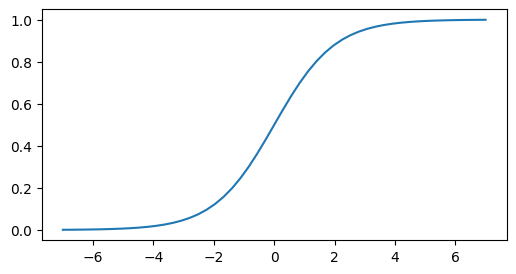

In [53]:
plt.figure(figsize=(6, 3))
plt.plot(z, sigmoid(z))
plt.show()

In [54]:
def linear_regression(xi):
    result = w0

    for j in range(len(w)):
        result = result + xi[j]*w[j]

    return result 

In [55]:
def logistic_regression(xi):
    score = w0

    for j in range(len(w)):
        score = score + xi[j]*w[j]
        
    result = sigmoid(score)
    
    return result 

### 10. Training Logistics Regression
- Train a model
- Apply to the validation dataset
- Calculate accuracy

In [56]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [57]:
model.intercept_[0]

-0.17736805365176891

In [58]:
model.coef_[0].round(3)

array([ 0.608, -0.057, -0.722, -0.054, -0.117,  0.021, -0.124, -0.067,
       -0.066, -0.104, -0.416,  0.37 , -0.124,  0.003, -0.264,  0.084,
        0.01 ,  0.023, -0.124, -0.07 ,  0.183, -0.124, -0.23 , -0.27 ,
        0.099, -0.142, -0.028, -0.129, -0.082,  0.05 , -0.009,  0.084,
       -0.254,  0.203, -0.133, -0.124,  0.087, -0.101, -0.124,  0.055,
        0.14 , -0.124, -0.187, -0.037,  0.003])

In [59]:
# Hard prediction
model.predict(X_train)

array([0, 1, 1, ..., 1, 0, 1])

In [60]:
# Soft prediction
y_pred = model.predict_proba(X_val)[:, 1]

In [61]:
churn_decision = (y_pred >= 0.5)

In [62]:
(y_val == churn_decision).mean()

0.8090844570617459

#### Explaination of above expression

In [63]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [64]:
df_pred['correct'] = (df_pred.prediction == df_pred.actual)

In [65]:
df_pred.correct.mean()

0.8090844570617459

### 11. Model Interpretation
- Look at the coefficient
- Train a smaller model with fewer feature

In [66]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.608,
 'contract=one_year': -0.057,
 'contract=two_year': -0.722,
 'dependents=no': -0.054,
 'dependents=yes': -0.117,
 'device_protection=no': 0.021,
 'device_protection=no_internet_service': -0.124,
 'device_protection=yes': -0.067,
 'gender=female': -0.066,
 'gender=male': -0.104,
 'internet_service=dsl': -0.416,
 'internet_service=fiber_optic': 0.37,
 'internet_service=no': -0.124,
 'monthly_charges': 0.003,
 'multiple_lines=no': -0.264,
 'multiple_lines=no_phone_service': 0.084,
 'multiple_lines=yes': 0.01,
 'online_backup=no': 0.023,
 'online_backup=no_internet_service': -0.124,
 'online_backup=yes': -0.07,
 'online_security=no': 0.183,
 'online_security=no_internet_service': -0.124,
 'online_security=yes': -0.23,
 'paperless_billing=no': -0.27,
 'paperless_billing=yes': 0.099,
 'partner=no': -0.142,
 'partner=yes': -0.028,
 'payment_method=bank_transfer_(automatic)': -0.129,
 'payment_method=credit_card_(automatic)': -0.082,
 'payment_method=electron

#### Training smaller model

In [67]:
small = ['contract', 'tenure', 'monthly_charges']

In [68]:
# Defining DictVectorizer
dv_small = DictVectorizer(sparse=False)

In [69]:
# Traning dataset
train_dicts = df_train[small].to_dict(orient='records')
X_train_small = dv_small.fit_transform(train_dicts)

# Validation dataset
val_dicts = df_val[small].to_dict(orient='records')
X_val_small = dv_small.fit_transform(val_dicts)

X_train_small.shape, X_val_small.shape

((4225, 5), (1409, 5))

In [70]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [71]:
w0 = model_small.intercept_[0]
w0

-2.4767756595983106

In [72]:
w = model_small.coef_[0].round(3)
w

array([ 0.97 , -0.025, -0.949,  0.027, -0.036])

In [73]:
dict(zip(dv_small.get_feature_names_out(), w))

{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthly_charges': 0.027,
 'tenure': -0.036}

In [74]:
sigmoid(-2.47 + (0.97) + 30*0.027 + (-0.036) * 24)

0.1745092945325032

### 12. Using Model

In [75]:
# Defining DictVectorizer
dv = DictVectorizer(sparse=False)

# Traning dataset
train_full_dicts = df_train_full[ numerical + categorical ].to_dict(orient='records')
X_train_full = dv.fit_transform(train_full_dicts)

# Testing dataset
test_dicts = df_test[ numerical + categorical].to_dict(orient='records')
X_test = dv.fit_transform(test_dicts)

X_train_full.shape, X_test.shape

((5634, 45), (1409, 45))

In [76]:
# Target variable
y_train_full = df_train_full.churn.values

In [77]:
# Training the model
model = LogisticRegression().fit(X_train_full, y_train_full)

In [78]:
# Soft prediction
y_pred = model.predict_proba(X_test)[:, 1]
churn_prediction = (y_pred >= 0.5)
(churn_prediction == y_test).mean()

0.8076650106458482

In [79]:
customer = test_dicts[10]
customer

{'tenure': 32,
 'monthly_charges': 93.95,
 'total_charges': 93.95,
 'gender': 'male',
 'senior_citizen': 1,
 'partner': 'yes',
 'dependents': 'yes',
 'phone_service': 'yes',
 'multiple_lines': 'no',
 'internet_service': 'fiber_optic',
 'online_security': 'no',
 'online_backup': 'yes',
 'device_protection': 'no',
 'tech_support': 'no',
 'streaming_tv': 'yes',
 'streaming_movies': 'yes',
 'contract': 'month-to-month',
 'paperless_billing': 'yes',
 'payment_method': 'mailed_check'}

In [80]:
X_customer = dv.transform([customer])

In [81]:
model.predict_proba(X_customer)[0, 1]

0.5184769067026507

In [82]:
y_test[10]

0

### 13. Summary